# Titanic Dataset - Machine Learning

This notebook tries to predict if a passenger has survived the disaster using machine learning techniques.

This kernel consists of the following sections.

- Data Loading
- Exploratory Data Analysis
- Feature Engineering
- Imputing missing values
- Feature Engineering
- Classifier Modeling
- Ensemble Modeling

In [197]:
import pandas as pd
import os
import numpy as np
import matplotlib .pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score, learning_curve

from collections import Counter

sns.set(style='white', context='notebook', palette='deep')

In [9]:
#Load data for train and test
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [12]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [14]:
#Outlier detection

def outliers(df, n, features):
    
    outlier_indices = []
    
    for col in features:
        
        #1st quartile
        Q1 = np.percentile(df[col], 25)
        
        #3rd quartile
        Q3 = np.percentile(df[col], 75)
        
        #inter quartile range
        IQR = Q3 - Q1
        
        #identify index of outlier rows
        outlierlist = df[(df[col] < (Q1 - (1.5 * IQR))) | (df[col] > (Q3 + (1.5 * IQR)))].index
        
        outlier_indices.extend(outlierlist)
        
    #selecting rows with more than two outliers
    outlier_indices = Counter(outlier_indices)
    multipleoutliers = list(k for k,v in outlier_indices.items() if v > n)
    
    return multipleoutliers

#detect outliers from Age, SibSp, Fare and Parch
finaloutliers = outliers(train, 2, ['Age', 'SibSp', 'Parch', 'Fare'])
        

C:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


In [15]:
#Find outliers to drop
train.iloc[finaloutliers]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [16]:
#Drop outliers from train set
train = train.drop(finaloutliers, axis = 0).reset_index(drop = True)

In [20]:
#Joining train and test sets

length = len(train)
dataset = pd.concat(objs=[train, test], axis = 0).reset_index(drop = True)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  after removing the cwd from sys.path.


In [23]:
#Checking for null values
dataset.isnull().sum()

Age             256
Cabin          1007
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

In [25]:
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
PassengerId    881 non-null int64
Survived       881 non-null int64
Pclass         881 non-null int64
Name           881 non-null object
Sex            881 non-null object
Age            711 non-null float64
SibSp          881 non-null int64
Parch          881 non-null int64
Ticket         881 non-null object
Fare           881 non-null float64
Cabin          201 non-null object
Embarked       879 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [26]:
#Data Summary
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


## Exploratory Data Analysis

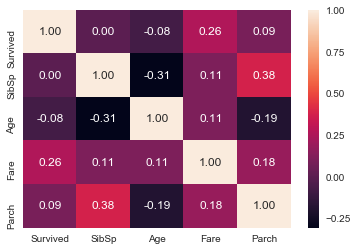

In [35]:
#Correlation matrix between numerical values SibSp, Age, Fare, Parch and response variable Survived
cor = sns.heatmap(train[['Survived','SibSp','Age','Fare','Parch']].corr(), annot=True, fmt = ".2f")

Fare feature seems to have the strongest correlation with survival. Let's explore other features a bit more to determine if there is any correlation with survival probability.

1. SibSp

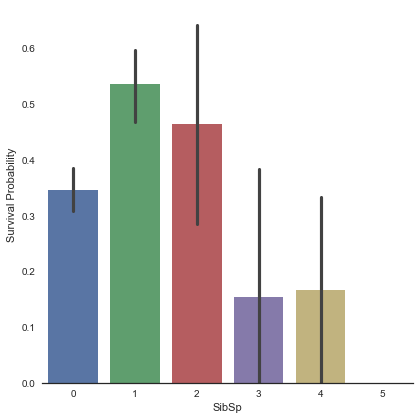

In [41]:
#Exploring SibSp feature

g = sns.factorplot(x="SibSp", y="Survived", data=train, kind='bar', size = 6)
g.despine(left = True)
g.set_ylabels("Survival Probability")

From the above plot, we can see that a person with more siblings/spouses have lesser chances to survive.

2. Parch

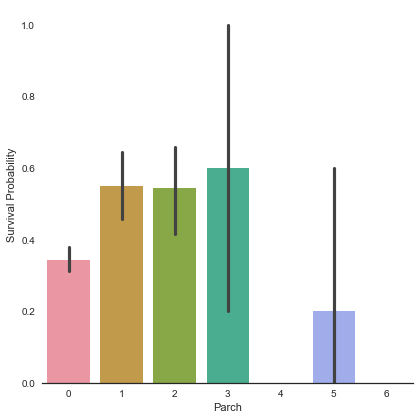

In [43]:
#Exploring Parch feature

g = sns.factorplot(x='Parch', y='Survived', data=train, kind='bar', size = 6)
g.despine(left = True)
g.set_ylabels("Survival Probability")

Small families seems to survive the most compared to single(Parch 0) and larger families(Parch = 4,5,6)

3. Age

C:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


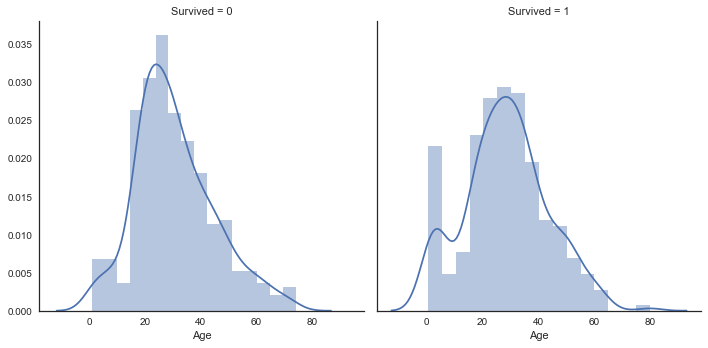

In [54]:
#Exploring age against survival

g = sns.FacetGrid(train, col='Survived', size = 5)
g = g.map(sns.distplot, 'Age')

Even though 'Age' feature was not strongly correlated to survival, we can see that people within a specific year range have got more chances to survive. Also, older people have survived the least. 

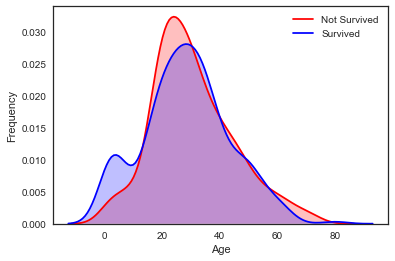

In [59]:
#Exploring age further by superimposing both the above plots

g = sns.kdeplot(train['Age'][(train['Survived']==0) & (train['Age'].notnull())], color = 'Red', shade = True)
g = sns.kdeplot(train['Age'][(train['Survived']==1) & (train['Age'].notnull())], color = 'Blue', ax = g, shade = True)

g.set_xlabel('Age')
g.set_ylabel('Frequency')
g.legend(['Not Survived','Survived'])

We can clearly see a peak corresponing to kids and young adults

4. Fare

In [60]:
#Checking for null values

dataset['Fare'].isnull().sum()

1

In [61]:
#Filling missing fare with the median value

dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())

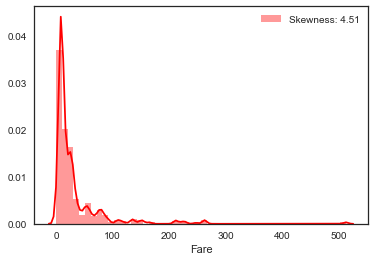

In [68]:
#Explore fare distribution
import warnings
warnings.filterwarnings('ignore')

g = sns.distplot(dataset['Fare'], color = 'r', label='Skewness: %.2f'%(dataset['Fare'].skew()))
g.legend(loc='Best')

In [70]:
#Applying log transoformation to reduce skewness in fare distribution

dataset['Fare'] = dataset['Fare'].map(lambda i: np.log(i) if i>0 else 0)

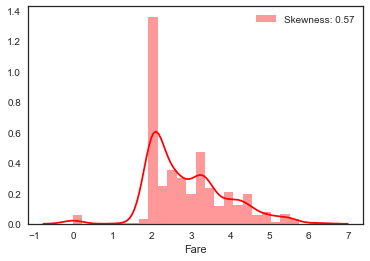

In [72]:
g = sns.distplot(dataset['Fare'], color = 'r', label='Skewness: %.2f'%(dataset['Fare'].skew()))
g.legend(loc='Best')

Skewness is clearly reduced by log transformation

## Exploring categorical values

Sex

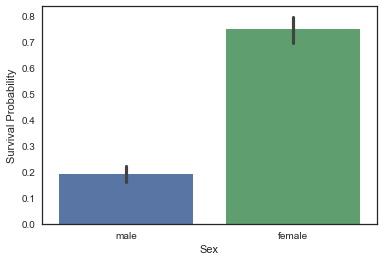

In [73]:
g = sns.barplot(x='Sex', y='Survived', data=train)
g = g.set_ylabel('Survival Probability')

It is quite clear than males have less probability of survival compared to females. Sex does play an important role in survival prediction.

Pclass

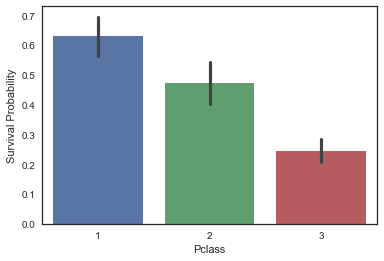

In [74]:
g = sns.barplot(x='Pclass', y='Survived', data=train)
g = g.set_ylabel('Survival Probability')

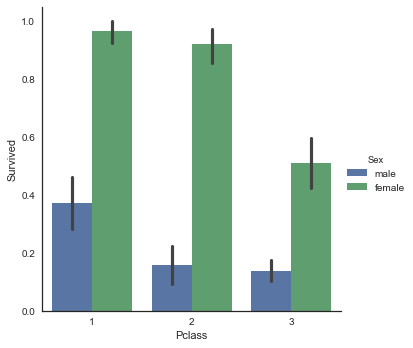

In [78]:
#Explore Pclass Vs Survived with respect to Sex
g = sns.factorplot(x='Pclass', y='Survived', hue='Sex', data=train, size =5, kind='bar')

Looking at the above plot, we can confirm that first class passengers have higher chances of survival compared to 2nd and 3rd class. This trend can be seen even when we split the data based on Sex. 

Embarked

In [79]:
#Checking number of null values
dataset['Embarked'].isnull().sum()

2

In [82]:
#Counting the number of occurences of each value in embarked
#This is done to impute missing the two missing values
embarkfreq = Counter(dataset['Embarked'])
embarkfreq

Counter({'S': 904, 'C': 270, 'Q': 123, nan: 2})

We can see that the most frequently occuring value is 'S'. We'll go ahead and impute the value for our two missing fields.

In [83]:
#Filling missing values
dataset['Embarked'] = dataset['Embarked'].fillna('S')

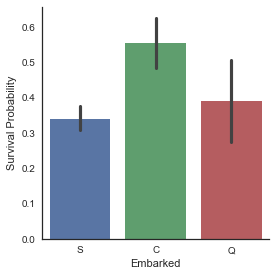

In [86]:
#Explore 'Embarked' with 'Survived'
g = sns.factorplot(x='Embarked', y='Survived', data=train, kind='bar')
g.set_ylabels('Survival Probability')

It seems that passengers boarded from Cherbourg has higher chances of survival. There might be a case where the people bpnarding from 'C' are mostly first class passengers.

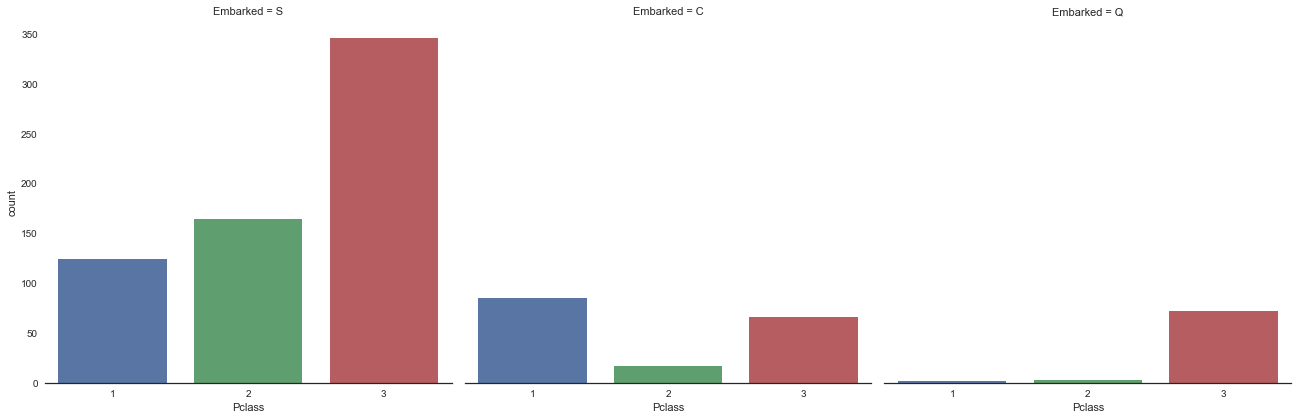

In [89]:
g = sns.factorplot("Pclass", col="Embarked",  data=train, size=6, kind="count")
g.despine(left=True)

## Imputing missing values

Age

In [90]:
dataset['Age'].isnull().sum()

256

Age feature has 256 missing values. But as we saw earlier, there are particular subpopulations that have higher chances of survival. So it is better to include the Age feature and try imputing the missing values.

Let's look the relation of Age feature with other features like Sex, Parch, Pclass, SibSp

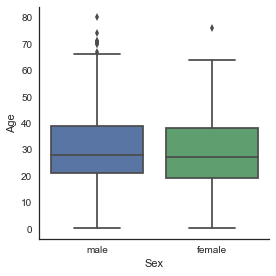

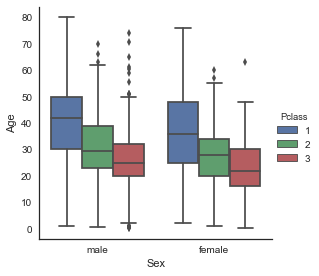

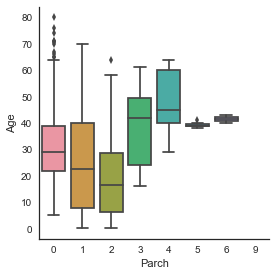

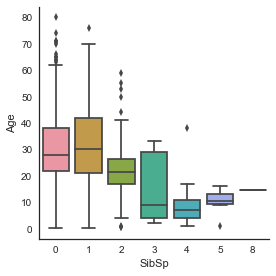

In [91]:
#Age vs Sex, Parch, Pclass, SibSp
g = sns.factorplot(y='Age', x='Sex', data=dataset, kind='box')
g = sns.factorplot(y='Age', x='Sex', hue='Pclass', data=dataset, kind='box')
g = sns.factorplot(y='Age', x='Parch', data=dataset, kind='box')
g = sns.factorplot(y='Age', x='SibSp', data=dataset, kind='box')

Sex doesn't seem to play a big role in determining age as the distrbutions across male and female are idenical. But passengers traveling in first class seem to be older than the ones traveling in 2nd and 3rd class.
Also, passengers with parents/childer seems to be older whereas passengers with more siblings/spouses seem to be younger.

In [92]:
#Converting sex into values of 0s and 1s for males and females respectively.
dataset['Sex'] = dataset['Sex'].map({'male':0, 'female':1})

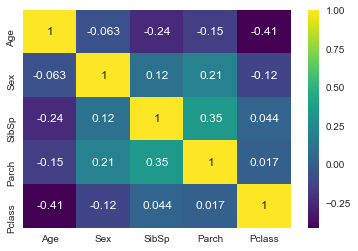

In [96]:
g = sns.heatmap(dataset[['Age', 'Sex','SibSp','Parch','Pclass']].corr(), cmap='viridis', annot=True)

We can see that Sex is not correlated with Age. But SibSp, Parch, Pclass are all negatively correlated with Age.

Hence we can try using these features to impute missing values in Age. 

In [101]:
#Filling missing values of Age

#Filling age with median value of similar rows according to Pclass, Parch, SibSp

age_index = list(dataset['Age'][dataset['Age'].isnull()].index)

for i in age_index:
    median_age = dataset['Age'].median()
    predicted_age = dataset['Age'][((dataset['SibSp'] == dataset.iloc[i]["SibSp"]) & \
                                    (dataset['Parch'] == dataset.iloc[i]['Parch']) & \
                                    (dataset['Pclass'] == dataset.iloc[i]['Pclass']))].median()
    if not np.isnan(predicted_age):
        dataset['Age'].iloc[i] = predicted_age
    else:
         dataset['Age'].iloc[i] = median_age  

In [102]:
dataset['Age'].isnull().sum()

0

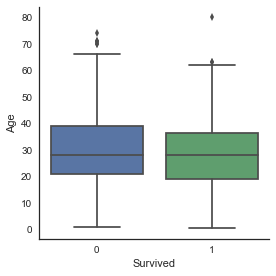

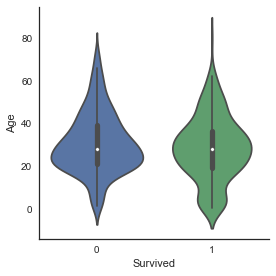

In [108]:
#Exploring Age vs Survival Probability

g = sns.factorplot(x="Survived", y = "Age",data = train, kind="box")
g = sns.factorplot(x="Survived", y = "Age",data = train, kind="violin")

We still don't see much of a distribution change in the box plots. But there is larger probability of survival of people in younger age groups as we see in the violin plot.

## Feature Engineering

Name

In [109]:
dataset['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

Lets extract just the title from the name. This will help us in checking if there is a correlation between title and survival probability. Based on the title, some people might have been evacuated first.

In [115]:
#Extract title from Name

title = [i.split(',')[1].split('.')[0].strip() for i in dataset['Name']]
dataset['Title'] = pd.Series(title)
dataset['Title'].head(5)

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

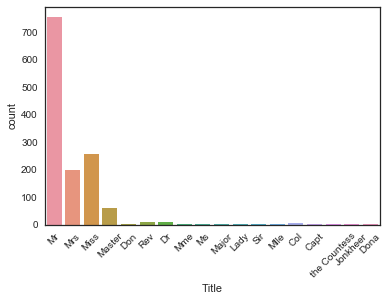

In [118]:
g = sns.countplot(x='Title', data=dataset)
g = plt.setp(g.get_xticklabels(), rotation = 45)

As we see from the above plot, most of the titles occur rarely. Hence it would be better to group these into four categories. 

In [120]:
#Convert to categorical values - Title
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', \
                                             'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
dataset["Title"] = dataset["Title"].astype(int)

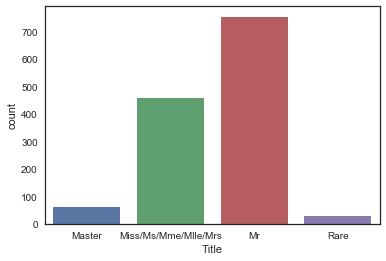

In [121]:
g = sns.countplot(x='Title', data=dataset)
g = g.set_xticklabels(["Master","Miss/Ms/Mme/Mlle/Mrs","Mr","Rare"])

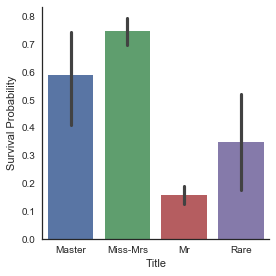

In [122]:
g = sns.factorplot(x="Title",y="Survived",data=dataset,kind="bar")
g = g.set_xticklabels(["Master","Miss-Mrs","Mr","Rare"])
g = g.set_ylabels("Survival Probability")

It is evident from the above plot that children and women had higher survival probability. Note that people will Rare title seems to have high probability as well compared to normal men.

We can drop the Name feature now from our data

In [123]:
dataset.drop(labels=['Name'], axis=1, inplace=True)

In [124]:
dataset.head()

,Age,Cabin,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title
0,22.0,NaN,S,1.981001,0,1,3,0,1,0.0,A/5 21171,2
1,38.0,C85,C,4.266662,0,2,1,1,1,1.0,PC 17599,1
2,26.0,NaN,S,2.070022,0,3,3,1,0,1.0,STON/O2. 3101282,1
3,35.0,C123,S,3.972177,0,4,1,1,1,1.0,113803,1
4,35.0,NaN,S,2.085672,0,5,3,0,0,0.0,373450,2


Family Size

A new feature family size is creating by adding SibSp and Parch features. There must be a correlation between the family size and associated survival probability.

In [125]:
dataset['FSize'] = dataset['SibSp'] + dataset['Parch'] + 1

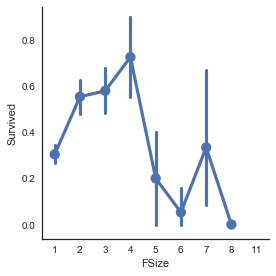

In [126]:
#Exploring family size feature Vs Survival
g = sns.factorplot(x='FSize', y='Survived', data = dataset)
g.set_ylabels('Survival Probability')

Survival size seems to be very bad for large families. Seems to make sense.

Let's group family size into four categories

In [128]:
#Creating four new categories based on family size
dataset['Single'] = dataset['FSize'].map(lambda s:1 if s==1 else 0)
dataset['SmallF'] = dataset['FSize'].map(lambda s:1 if s==2 else 0)
dataset['MediumF'] = dataset['FSize'].map(lambda s:1 if 3<=s<=4 else 0)
dataset['LargeF'] = dataset['FSize'].map(lambda s:1 if s>=5 else 0)

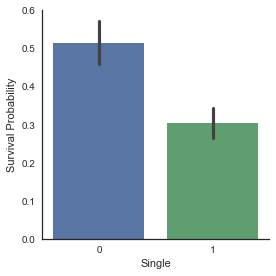

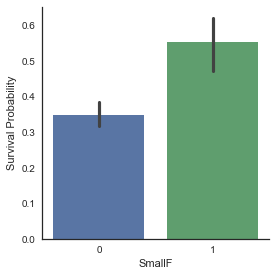

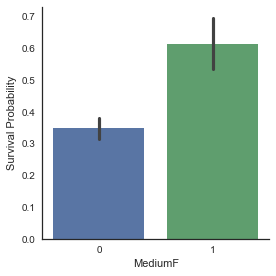

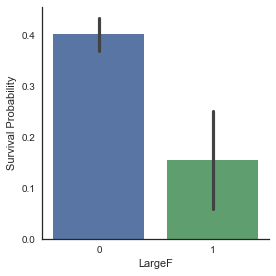

In [129]:
g = sns.factorplot(x='Single', y='Survived', data=dataset, kind='bar')
g.set_ylabels('Survival Probability')
g = sns.factorplot(x='SmallF', y='Survived', data=dataset, kind='bar')
g.set_ylabels('Survival Probability')
g = sns.factorplot(x='MediumF', y='Survived', data=dataset, kind='bar')
g.set_ylabels('Survival Probability')
g = sns.factorplot(x='LargeF', y='Survived', data=dataset, kind='bar')
g.set_ylabels('Survival Probability')

Small and Medium Families seem to have higher survival rate compared to large families or singles.

In [ ]:
#Encode values Title and Embarked

dataset = pd.get_dummies(dataset, columns = ['Title'])
dataset = pd.get_dummies(dataset, columns = ['Embarked'], prefix = 'Em')

In [138]:
dataset.head()

,Age,Cabin,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,...,SmallF,MediumF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,22.0,NaN,1.981001,0,1,3,0,1,0.0,A/5 21171,...,1,0,0,0,0,1,0,0,0,1
1,38.0,C85,4.266662,0,2,1,1,1,1.0,PC 17599,...,1,0,0,0,1,0,0,1,0,0
2,26.0,NaN,2.070022,0,3,3,1,0,1.0,STON/O2. 3101282,...,0,0,0,0,1,0,0,0,0,1
3,35.0,C123,3.972177,0,4,1,1,1,1.0,113803,...,1,0,0,0,1,0,0,0,0,1
4,35.0,NaN,2.085672,0,5,3,0,0,0.0,373450,...,0,0,0,0,0,1,0,0,0,1


Currently we have 21 features in out dataset

Cabin

In [140]:
dataset['Cabin'].describe()

count                 292
unique                186
top       B57 B59 B63 B66
freq                    5
Name: Cabin, dtype: object

In [141]:
#Check for null values
dataset['Cabin'].isnull().sum()

1007

Seems like most passengers without a cabin have just nulls in the cabin field

In [142]:
#Replace the Cabin number by the type of cabin. Replace with 'X' if null
dataset["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin'] ])

We just retained the first letter in the cabin number which indicated the desk they were located at. It might be helpful in identifying where the passenger was located.

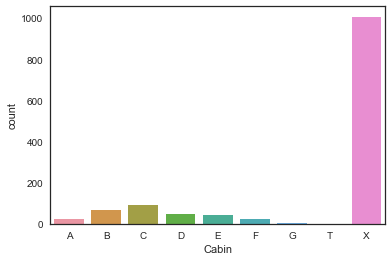

In [147]:
#Counting the number of occurences of each cabin
g = sns.countplot(x='Cabin',order=['A','B','C','D','E','F','G','T','X'], data=dataset)

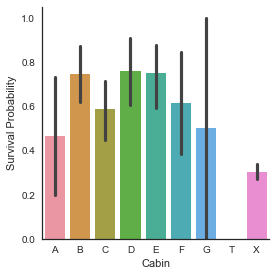

In [152]:
#Exploring Cabin Vs Survival
g = sns.factorplot(x='Cabin', y='Survived', data=dataset, order=['A','B','C','D','E','F','G','T','X'], kind ='bar')
g.set_ylabels('Survival Probability')

We can see that generally people with cabins have had better survival probability compared to people with no cabins in 'X'

In [153]:
dataset = pd.get_dummies(dataset, columns = ['Cabin'], prefix = 'Cabin')

Ticket

In [154]:
dataset['Ticket'].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

Ticket prefix might be more valuable to us than the ticket number itself. Ticket prefix may indicate the actual cabins that they are booked for and can also give more detail on the passenger class and survival probability.

Lets extract the prefix from ticket number

In [156]:
#Extracting prefix from ticket

ticket = []
for i in list(dataset['Ticket']):
    if not i.isdigit():
        ticket.append(i.replace('.','').replace('/','').strip().split(' ')[0])
    else:
        ticket.append('X')

dataset['Ticket'] = ticket
dataset['Ticket'].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [157]:
#Creating dummy variables for ticket values
dataset = pd.get_dummies(dataset, columns = ['Ticket'], prefix = 'T')

In [159]:
#Create dummy variable for Pclass
dataset = pd.get_dummies(dataset, columns = ['Pclass'], prefix = 'Pc')

In [160]:
#Drop unwanted features
dataset.drop(labels = ['PassengerId'], axis = 1, inplace = True)

In [164]:
dataset.head()

,Age,Fare,Parch,Sex,SibSp,Survived,FSize,Single,SmallF,MediumF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,22.0,1.981001,0,0,1,0.0,2,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,38.0,4.266662,0,1,1,1.0,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,26.0,2.070022,0,1,0,1.0,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,35.0,3.972177,0,1,1,1.0,2,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,35.0,2.085672,0,0,0,0.0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1


Our final dataset now has 67 features. 

Let's start with modeling now. 

## Predictive Modeling

In [165]:
#Splitting train and test set

train = dataset[:length]
test = dataset[length:]
test.drop(labels = ['Survived'], axis = 1, inplace = True)

In [171]:
#Train split to X_train, y_train

train['Survived'] = train['Survived'].astype(int)
y_train = train['Survived']
X_train = train.drop(labels = ['Survived'], axis = 1)

The following 10 classifiers were used and their mean accuracy was evaluated based on stratified kfold cross validation

- SVC
- Decision Tree
- AdaBoost
- Random Forest
- Extra Trees
- Multi layer perceptron (NN)
- KNN
- Logistic Regression
- Linear Discriminant Analysis
- Gradient Boosting

In [172]:
#Stratified kfold cross validation

kfold = StratifiedKFold(n_splits=10)

In [174]:
#Estimating the mean accuracy of different models on train dataset
random_state = 2
classifiers = []

classifiers.append(SVC(random_state = random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state) \
                                      , random_state=random_state, learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state=random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for model in classifiers:
    cv_results.append(cross_val_score(model, X_train, y_train, scoring='accuracy', cv=kfold, n_jobs=4))
    
cv_means = []
cv_std = []

for result in cv_results:
    cv_means.append(result.mean())
    cv_std.append(result.std())
    
table = pd.DataFrame({'MeanAccuracy':cv_means, 'Errors':cv_std, 'Model':['SVC','DecisionTree','AdaBoost','RandomForest', \
                    'ExtraTrees','GradientBoosting', 'Multiple Layer Perceptron', 'KNeighbors', \
                                                        'LogisticRegression', 'LinearDiscriminantAnalysis']})

In [175]:
#Models and their associated accuracy and errors
table

,MeanAccuracy,Errors,Model
0,0.822944,0.045155,SVC
1,0.795774,0.039714,DecisionTree
2,0.801456,0.054777,AdaBoost
3,0.814977,0.035252,RandomForest
4,0.807035,0.036652,ExtraTrees
5,0.829724,0.041959,GradientBoosting
6,0.824068,0.034157,Multiple Layer Perceptron
7,0.795710,0.040837,KNeighbors
8,0.822932,0.033765,LogisticRegression
9,0.822932,0.038751,LinearDiscriminantAnalysis


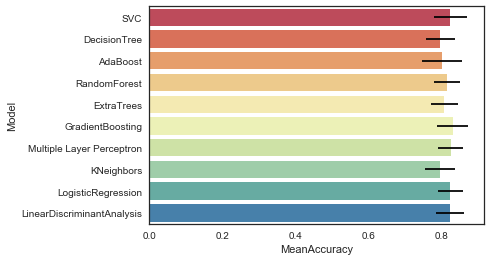

In [184]:
# Plot Model accuracy
g = sns.barplot(x='MeanAccuracy', y='Model', palette= 'Spectral', data=table, orient='h', **{'xerr':cv_std})

Out of the 10 classfiers, 

SVC, GradientBoost, RandomForest, AdaBoost and ExtraTrees are chosen for ensemble modeling. 

## Hyperparameter Tuning

### Grid Search Optimization

In [187]:
# Adaboost

DTmodel = DecisionTreeClassifier()

adaModel = AdaBoostClassifier(DTmodel, random_state=0)

ada_grid = {'base_estimator__criterion': ['gini','entropy'], \
           'base_estimator__splitter': ['best', 'random'], \
           'algorithm': ['SAMME','SAMME.R'], \
           'n_estimators': [1,2], \
           'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gridsearch = GridSearchCV(adaModel, param_grid=ada_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)

gridsearch.fit(X_train, y_train)

ada_best = gridsearch.best_estimator_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


[Parallel(n_jobs=4)]: Done 165 tasks      | elapsed:    3.3s
[Parallel(n_jobs=4)]: Done 1120 out of 1120 | elapsed:    5.7s finished


In [190]:
gridsearch.best_score_

0.8297389330306469

In [191]:
# Extra Trees

ETmodel = ExtraTreesClassifier(random_state=0)

ETparams = {'max_depth': [None], 'max_features': [1, 3, 10], 'min_samples_split': [2, 3, 10], \
         'min_samples_leaf': [1, 3, 10], 'bootstrap': [False], 'n_estimators': [100,300], 'criterion': ['gini'] }

ETgrid = GridSearchCV(ETmodel, param_grid=ETparams, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)

ETgrid.fit(X_train, y_train)

ET_best = ETgrid.best_estimator_

#Best Score
ETgrid.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   17.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   39.4s
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:   48.4s finished


0.8286038592508513

In [192]:
# Random Forest

RFmodel = RandomForestClassifier(random_state=0)

RFparams = {'max_depth': [None], 'max_features': [1, 3, 10], 'min_samples_split': [2, 3, 10], \
         'min_samples_leaf': [1, 3, 10], 'bootstrap': [False], 'n_estimators': [100,300], 'criterion': ['gini'] }

RFgrid = GridSearchCV(RFmodel, param_grid=RFparams, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)

RFgrid.fit(X_train, y_train)

RF_best = RFgrid.best_estimator_

#Best Score
RFgrid.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   20.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   46.0s
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:   56.5s finished


0.8320090805902384

In [193]:
# Gradient Boosting Trees

GBmodel = GradientBoostingClassifier(random_state=0)

GBparams = {'loss':['deviance'], 'n_estimators':[100,200,300], 'learning_rate':[0.1, 0.05, 0.01], 'max_depth': [4,8], \
           'min_samples_leaf': [100, 150], 'max_features': [0.3, 0.1]}

GBgrid = GridSearchCV(GBmodel, param_grid=GBparams, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)

GBgrid.fit(X_train, y_train)

GB_best = GBgrid.best_estimator_

#Best Score
GBgrid.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.5s
[Parallel(n_jobs=4)]: Done 308 tasks      | elapsed:   13.1s
[Parallel(n_jobs=4)]: Done 720 out of 720 | elapsed:   26.1s finished


0.8376844494892168

In [198]:
# Support Vector Classifier

SVCmodel = SVC(probability=True)

SVCparams = {'kernel': ['rbf'], 'gamma': [0.001, 0.01, 0.1, 1], 'C': [1, 10, 50, 100, 200, 300, 1000]}

SVCgrid = GridSearchCV(SVCmodel, param_grid=SVCparams, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)

SVCgrid.fit(X_train, y_train)

SVC_best = SVCgrid.best_estimator_

#Best Score
SVCgrid.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   19.1s
[Parallel(n_jobs=4)]: Done 280 out of 280 | elapsed:   30.0s finished


0.8331441543700341

### Learning Curves 

One of the best ways to spot overfitting is using learning curves. This also explains the effect of increasing training set size on training score and cross val score

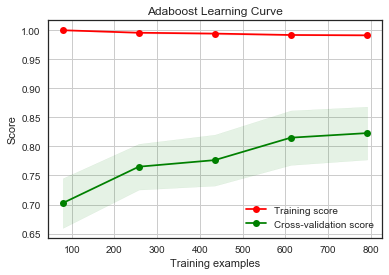

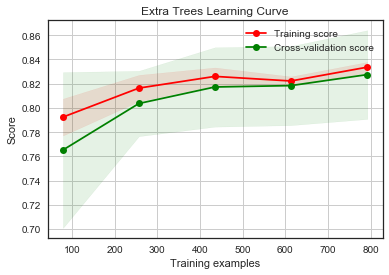

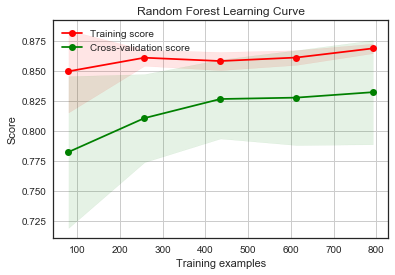

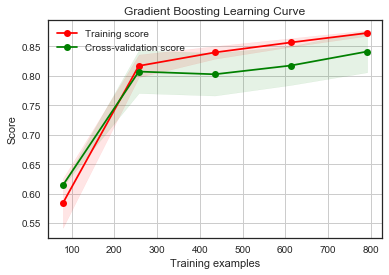

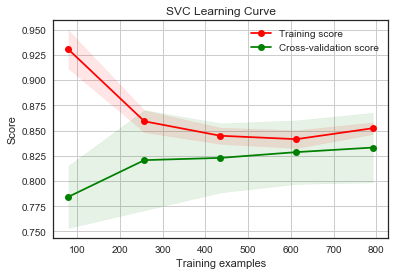

In [200]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(ada_best, 'Adaboost Learning Curve', X_train, y_train, cv = kfold)
g = plot_learning_curve(ET_best, 'Extra Trees Learning Curve', X_train, y_train, cv = kfold)
g = plot_learning_curve(RF_best, 'Random Forest Learning Curve', X_train, y_train, cv = kfold)
g = plot_learning_curve(GB_best, 'Gradient Boosting Learning Curve', X_train, y_train, cv = kfold)
g = plot_learning_curve(SVC_best, 'SVC Learning Curve', X_train, y_train, cv = kfold)

From the learning curve plots, we can see that Adaboost tends to overfit the data as we see high variance.

SVC and Extra Trees classifier seem to perform the best as they generalize well to increased training data. They also tend to have closer train and cross val scores.

### Feature Importance of Tree based classifiers

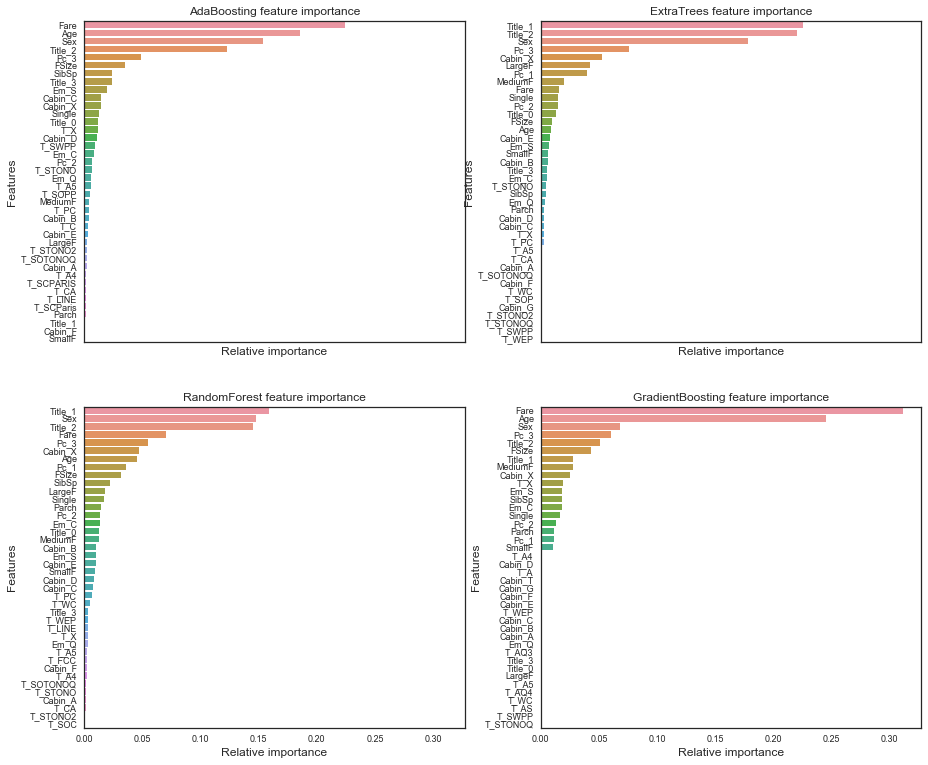

In [206]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,13))

names_classifiers = [("AdaBoosting", ada_best),("ExtraTrees",ET_best),("RandomForest",RF_best),("GradientBoosting",GB_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=X_train.columns[indices][:40],x = classifier.feature_importances_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1

We see that all four classifiers have different top features based on their relative importance. They still tend to have some common features like Age, Sex, Fare and Title2(Refers to women - Mrs, Miss)

The location in the ship doesn't seem to matter much as non of the Cabin features are at the top

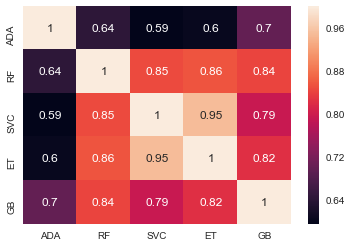

In [207]:
# Test set results

test_ADA = pd.Series(ada_best.predict(test), name='ADA')
test_RF = pd.Series(RF_best.predict(test), name='RF')
test_SVC = pd.Series(SVC_best.predict(test), name='SVC')
test_ET = pd.Series(ET_best.predict(test), name='ET')
test_GB = pd.Series(GB_best.predict(test), name='GB')

#Putting all results in one place
ensemble = pd.concat([test_ADA, test_RF, test_SVC, test_ET, test_GB], axis = 1)

#Correlation between all results
g = sns.heatmap(ensemble.corr(), annot=True)

There seems to be some similarity in the predictions of the 5 classifiers. ADA seems to be the one odd one out though. There is still enough differences between all 5 to build an ensemble classifier.

### Combining all 5 models - Ensemble Classifier

In [208]:
# Voting Classifer
votingModel = VotingClassifier(estimators=[('rf', RF_best), ('et', ET_best), ('svc', SVC_best), \
                                           ('ada', ada_best), ('gb', GB_best)], n_jobs = 4)

votingModel.fit(X_train, y_train)

VotingClassifier(estimators=[('rf', RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=10,
            min_weigh...         presort='auto', random_state=0, subsample=1.0, verbose=0,
              warm_start=False))],
         flatten_transform=None, n_jobs=4, voting='hard', weights=None)

## Final Prediction Based on Ensemble Modeling

In [210]:
prediction = pd.Series(votingModel.predict(test), name='Survived')

In [217]:
#Obtaining the passengerID

test2 = pd.read_csv('test.csv')
PassengerID = test2['PassengerId']

In [218]:
# Final Results

results = pd.concat([PassengerID, prediction], axis=1)